## Data

https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle

In [18]:
RANDOM_STATE = 42

In [ ]:
!unzip images.zip -d iamges

In [ ]:
!unzip masks.zip -d masks

In [7]:
import numpy as np

In [10]:
from google.colab.patches import cv2_imshow

In [34]:
import cv2
import os

def load_images_from_folder(folder, is_mask, resize_shape=(512, 512)):
    images = []
    i = 0
    for filename in os.listdir(folder):
        if is_mask:
            img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(os.path.join(folder,filename))

        if img is not None:
            img = cv2.resize(img, resize_shape, interpolation = cv2.INTER_AREA)
            images.append(img)
        i+=1
        if i == 100:
            break
        
    return np.array(images)

In [35]:
images = load_images_from_folder('/content/images/Images', is_mask=False)

In [36]:
masks = load_images_from_folder('/content/masks/Masks', is_mask=True)

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(images, masks, test_size=0.15, shuffle=True, random_state=RANDOM_STATE)

In [38]:
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=RANDOM_STATE)

In [39]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'Val shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')

Train shapes: (76, 512, 512, 3), (76, 512, 512)
Val shapes: (9, 512, 512, 3), (9, 512, 512)
Test shapes: (15, 512, 512, 3), (15, 512, 512)


## Model

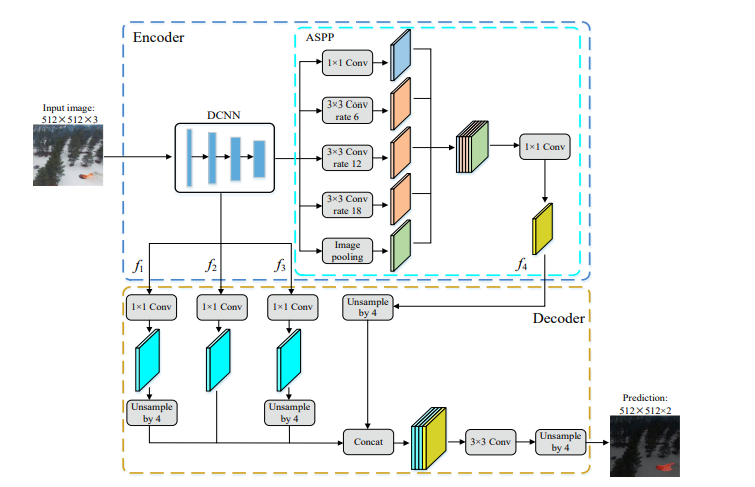

In [ ]:
# With square kernels and equal stride
m = nn.Conv2d(16, 33, 3, stride=2)
# non-square kernels and unequal stride and with padding
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
# non-square kernels and unequal stride and with padding and dilation
m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
input = torch.randn(20, 16, 50, 100)
output = m(input)

In [49]:
from torchvision.models.segmentation import deeplabv3_resnet101
model = deeplabv3_resnet101(pretrained=True, progress=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model

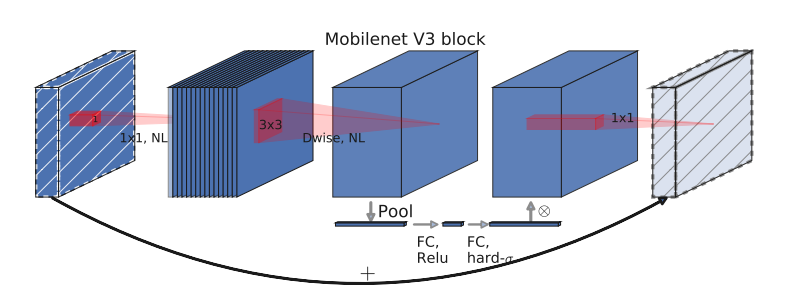

In [51]:
import torch
from torch import nn 
import torch.nn.functional as F

In [179]:
class MobileBottleNeck(nn.Module):

    def __init__(self, in_channels, expansion, out_channels, kernel_size, activation_layer, use_squeeze_excitation, stride=1, padding=1):
        super(MobileBottleNeck, self).__init__()

        self.use_skip_conn = stride == 1 and in_channels == out_channels
        self.use_squeeze_excitation = use_squeeze_excitation

        self.standard_conv = nn.Sequential(
            nn.Conv2d(in_channels, expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(expansion),
            activation_layer(),
        )


        # DEPTH-WISE CONV


        self.depthwise_conv = nn.Sequential(
            nn.Conv2d(expansion, expansion, kernel_size=kernel_size, stride=stride, 
                                        groups=expansion, padding=padding, bias=False),
            nn.BatchNorm2d(expansion),
        )

        # SQUEEZE-AND-EXCITATION

        self.squeeze_excitation = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Conv2d(expansion, in_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, expansion, kernel_size=1),
            nn.Hardswish(),
        )


        # POINTWISE CONVOLUTION
        self.pointwise_conv = nn.Sequential( 
            nn.Conv2d(expansion, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            activation_layer(),
        )

    def forward(self, x):
        residual = x.clone()

        # STANDARD CONV
        out = self.standard_conv(x)

        # DEPTH-WISE CONV
        depth_wise_out = self.depthwise_conv(out)
        if self.use_squeeze_excitation:
            # SQUEEZE-AND-EXCITATION
            out = self.squeeze_excitation(depth_wise_out)

            out = out * depth_wise_out    
        
        else:
            out = depth_wise_out

            
        # POINTWISE CONVOLUTION
        out = self.pointwise_conv(out)

        if self.use_skip_conn:
            out = out + residual

        return out

In [178]:
class DCNN(nn.Module):
    def __init__(self):
        super().__init__()
        in_channels = 3

        # INPUT LAYERS
        self.input_convolution = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.Hardswish(),
        )

        # BOTTLENECKS 
        self.bottleneck1 =  nn.Sequential(
            MobileBottleNeck(16, 16, 16, 3, nn.ReLU, False, stride=1),
        )

        self.bottleneck2 =  nn.Sequential(
            MobileBottleNeck(16, 64, 24, 3, nn.ReLU, False, stride=2, padding=1),
            MobileBottleNeck(24, 72, 24, 3, nn.ReLU, False, stride=1),
        )

        self.bottleneck3 =  nn.Sequential(
            MobileBottleNeck(24, 72, 40, 5, nn.ReLU, True, stride=2, padding=2),
            MobileBottleNeck(40, 120, 40, 5, nn.ReLU, True, stride=1, padding=2),
            MobileBottleNeck(40, 120, 40, 5, nn.ReLU, True, stride=1, padding=2),
        )    
        self.bottleneck4 =  nn.Sequential(        
            MobileBottleNeck(40, 240, 80, 3, nn.Hardswish, False, stride=2),
            MobileBottleNeck(80, 200, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 184, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 184, 80, 3, nn.Hardswish, False, stride=1),
            MobileBottleNeck(80, 480, 112, 3, nn.Hardswish, True, stride=1),
            MobileBottleNeck(112, 672, 160, 3, nn.Hardswish, True, stride=1),
            MobileBottleNeck(160, 672, 160, 5, nn.Hardswish, True, stride=1, padding=2),
            MobileBottleNeck(160, 960, 160, 5, nn.Hardswish, True, stride=1, padding=2),
            MobileBottleNeck(160, 960, 160, 5, nn.Hardswish, True, stride=1, padding=2),
        )

    def forward(self, x):
        out = self.input_convolution(x)
        f1 = self.bottleneck1(out)
        f2 = self.bottleneck2(f1)
        f3 = self.bottleneck3(f2)
        out = self.bottleneck4(f3)
        
        return f1, f2, f3, out

In [116]:
class ASPP(nn.Module):
    def __init__(self):
        super().__init__()

        in_channels = 160
        out_channels = 256

        # STANDARD CONVOLUTION LAYER

        self.standard_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        # ATROUS CONVOLUTION LAYERS

        self.atrous_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=6, padding=6),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.atrous_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=12, padding=12),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.atrous_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, bias=False, dilation=18, padding=18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        # IMAGE POOLING
        self.image_pooling = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(out_channels*5, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x):

        out1 = self.standard_conv(x)
        out2 = self.atrous_conv_1(x)
        out3 = self.atrous_conv_2(x)
        out4 = self.atrous_conv_3(x)

        out5 = self.image_pooling(x)
        # replicate spatially the pooling result
        out5 = F.interpolate(out5, size=x.shape[-2:], mode='bilinear', align_corners=False)

        out = torch.cat([out1, out2, out3, out4, out5], dim=1)
        f4 = self.final_conv(out)

        return f4

In [ ]:
t1 = torch.randn(72, 2, 1, 1)
t2 = torch.randn(72, 2, 65, 65)
t2*t1

In [121]:
tensor = torch.randn(2, 3, 512, 512)

In [117]:
import torch
from torch import nn 

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dcnn = DCNN()
        self.aspp = ASPP()

    def forward(self, x):
        f1, f2, f3, out = self.dcnn(x)
        f4 = self.aspp(out)
        print(f1.shape, f2.shape, f3.shape, f4.shape)
        return f1, f2, f3, f4 

In [180]:
enc = Encoder()
enc(tensor)

torch.Size([2, 16, 256, 256]) torch.Size([2, 24, 128, 128]) torch.Size([2, 40, 64, 64]) torch.Size([2, 256, 32, 32])


(tensor([[[[-2.6693e-01,  1.7336e-02,  1.0748e+00,  ...,  8.9931e-01,
             1.6102e-01,  1.2189e-01],
           [-9.7354e-02,  4.0586e-01, -2.1388e-01,  ...,  3.5254e+00,
            -3.0631e-01,  2.9052e+00],
           [ 9.3089e-01,  2.7504e-01,  3.6316e-02,  ...,  3.9753e-02,
             8.4773e-01,  3.1957e-01],
           ...,
           [-2.8376e-01,  4.1396e-01,  2.7745e-01,  ...,  1.3508e+00,
            -1.6252e-01, -2.2452e-01],
           [ 8.6385e-02, -2.0343e-01, -2.6425e-01,  ...,  8.7050e-01,
             9.0016e-01,  3.2333e-01],
           [-2.7287e-01, -2.7187e-01,  1.0255e-01,  ...,  2.4642e+00,
            -6.4700e-02,  5.2092e-02]],
 
          [[ 4.5102e-01,  3.5008e-01,  1.5870e-01,  ...,  1.1452e+00,
             1.3136e+00,  6.2267e-01],
           [ 7.2367e-01, -2.5367e-01,  3.0827e-01,  ...,  3.5151e-01,
            -3.0670e-01,  9.8867e-01],
           [-2.3139e-01,  8.4266e-01,  4.2118e-01,  ...,  4.9990e-01,
             6.8950e-01, -3.4563e-01],


In [ ]:
import torch
from torch import nn 

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        


In [ ]:
import torch
from torch import nn 

class FireSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        